In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError



In [3]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [4]:
ds

<xarray.Dataset>
Dimensions:          (time: 365, lat: 284, lon: 644)
Coordinates:
  * time             (time) object 2015-01-01 12:00:00 ... 2015-12-31 12:00:00
  * lat              (lat) float64 14.12 14.38 14.62 14.88 ... 84.38 84.62 84.88
  * lon              (lon) float64 190.1 190.4 190.6 190.9 ... 350.4 350.6 350.9
Data variables:
    tasmax           (time, lat, lon) float32 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
    above_threshold  (time, lat, lon) float32 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
    extreme_yn       (time, lat, lon) float64 dask.array<chunksize=(365, 284, 644), meta=np.ndarray>
Attributes: (12/24)
    Dataset:                                             1-year Extreme max T...
    About dataset:                                       1-year Extreme max T...
    Data variables:                                      tasmax, above_thresh...
    Data description:                                    max temperature; dif...
    Range:                                               1 year
    Analysis year:                                       2015
    ...                                                  ...
    region_bottom_lat:                                   14
    region_left_lon:                                     190
    region_right_lon:                                    350
    region_img_url:                                      https://github.com/t...
    Years processed:                                     1
    Store as:                                            Ext_max_t__Rgn_1__20...

6811


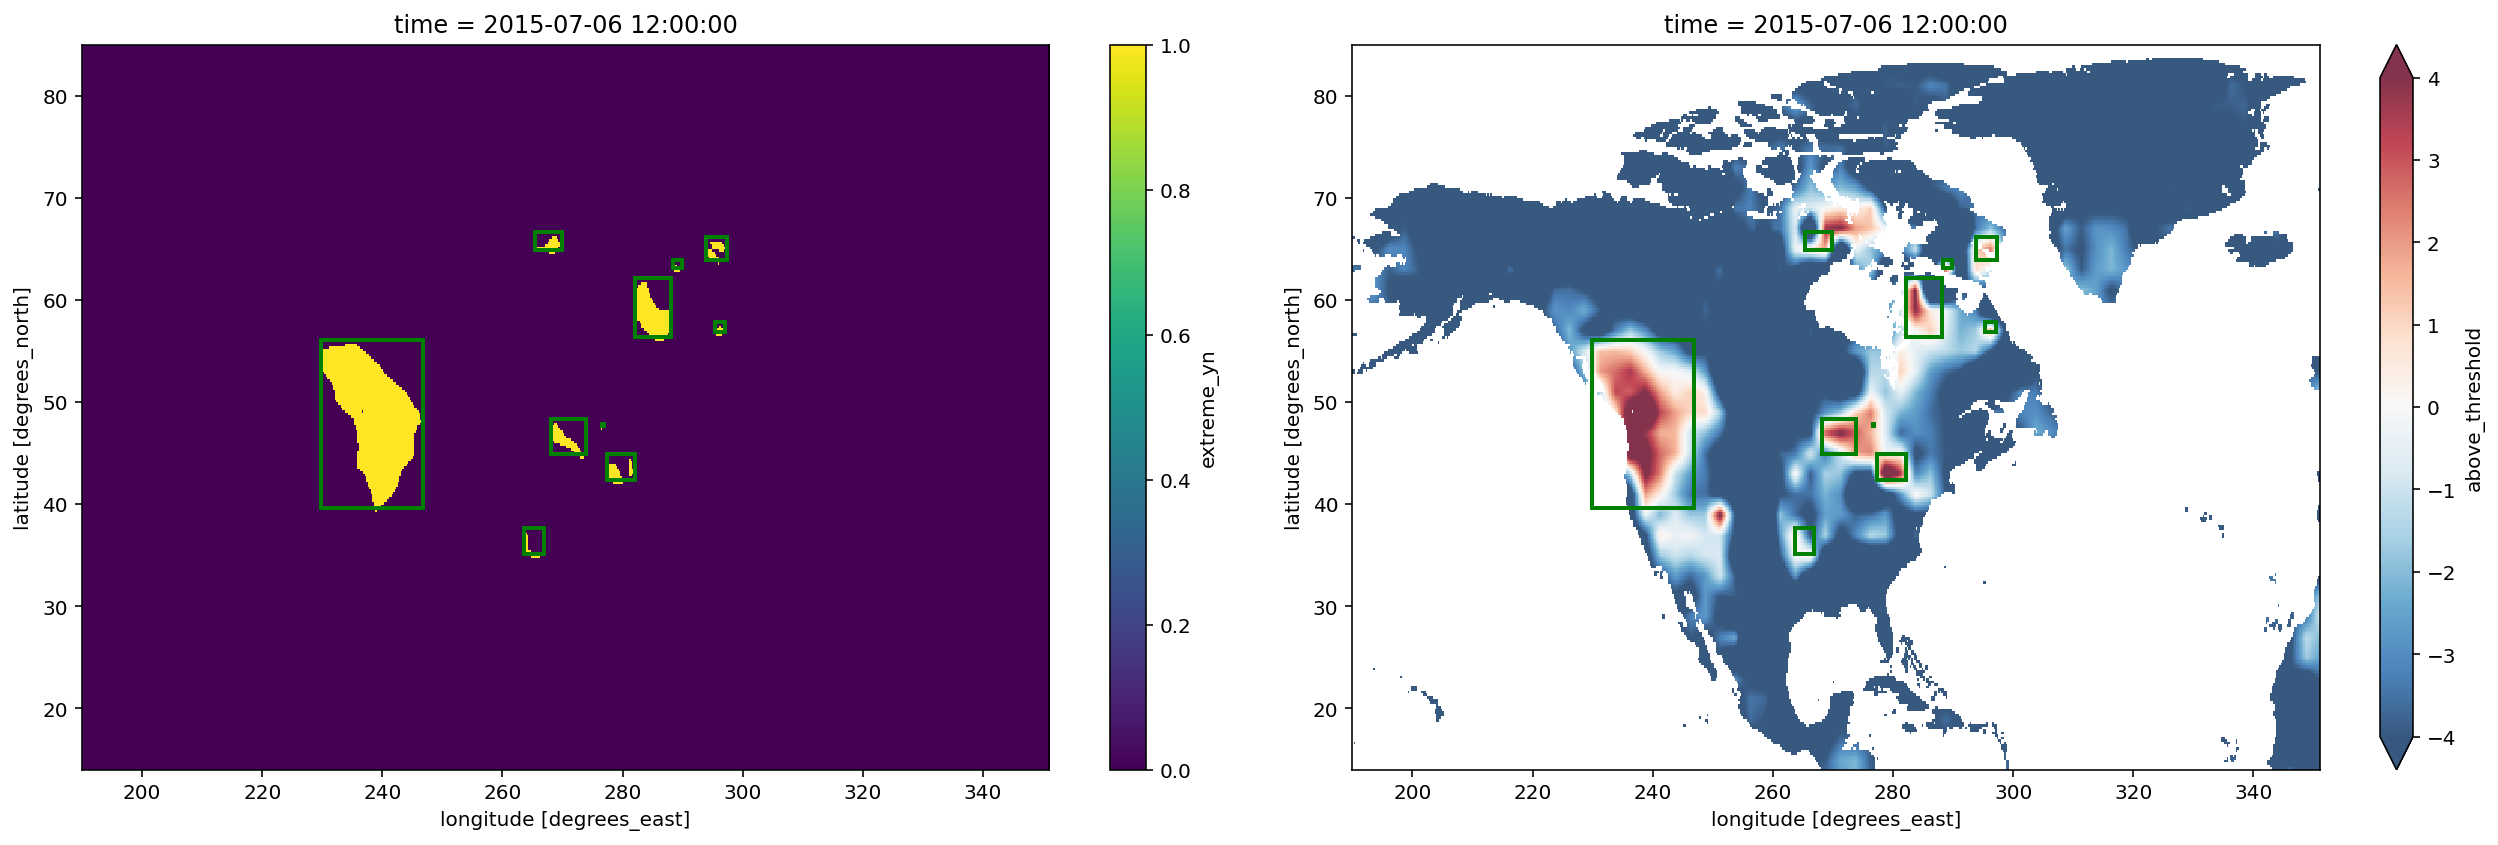

In [50]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW bounding-boxes algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

def countours(arr2d: np.array) -> List[tuple]:
    """Encapsulates clusters of 1s and returns many boxes, [(x1,x2,y1,y2),(..),]."""
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)

    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
    print(cv2.drawContours(H,[contours[0]], 0, (36,255,12), 2).sum())
    
    boxes = [cv2.boundingRect(c) for c in contours]
    
    return boxes

####################################
# Visualize
####################################

dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
lat_min, lat_max = ds['lat'].min(), ds['lat'].max()
lon_min, lon_max = ds['lon'].min(), ds['lon'].max()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

idx = 186

day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# add bounding boxes
# boxes = df_boxes['boxes'].iloc[ev]
arr2d = extreme.values[0]
boxes = countours(arr2d)
for b in boxes:
    x,y,w,h = b
    x = float(tdiff.coords['lon'][x])
    y = float(tdiff.coords['lat'][y])
    _, leny, lenx = tdiff.shape

    w = w * (lon_max-lon_min) / lenx
    h = h * (lat_max-lat_min) / leny 

    rect = Rectangle((x, y), w, h, color='g', fill=False, linewidth=2)
    ax1.add_patch(rect)

    rect = Rectangle((x, y), w, h, color='g', fill=False, linewidth=2)
    ax2.add_patch(rect)

fig.tight_layout()
        